In [176]:
import json
from typing import Dict, List
import numpy as np
from matplotlib import pyplot as plt
import os, sys
import librosa
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
from Signal_processing_utils import intensity_from_signal, pitch_from_signal, sparse_key_smoothing, laplacian_smoothing
from Speech_Data_util import Sentence_word_phone_parser
from prototypes.InputDataStructures import Dietic_Conversation_Gaze_Scene_Info
from prototypes.MVP.MVP_static_saliency_list import ObjectBasedFixSaliency
from prototypes.MVP.MVP_Aversion_saliency_list import AversionSignalDrivenSaliency, CTSAversionSignalDrivenSaliency
from prototypes.MVP.MVP_look_at_point_planner import HabituationBasedPlanner, RandomPlanner, PartnerHabituationPlanner
from prototypes.MVP.MVP_eye_head_driver import HeuristicGazeMotionGenerator

from prototypes.EyeCatch.Saccade_model_with_internal_model import *
from prototypes.Gaze_aversion_prior.Heuristic_model import *
from prototypes.Boccignone2020.Gaze_target_planner import Scavenger_based_planner
from prototypes.Boccignone2020.Improved_gaze_target_planner import Scavenger_planner_with_nest
from prototypes.JaliNeck.JaliNeck import NeckCurve
from prototypes.Gaze_aversion_prior.Ribhav_model import predict_aversion
from prototypes.InputDataStructures import AgentInfo, TurnTakingData
import pickle
import math
from datetime import datetime

# Input Block

In [179]:
np.random.seed(0)
# inputs
input_folder = "/Users/evanpan/Documents/Datasets/Ribhav_processed_dataset/"
input_file = "Madelaine Petsch audition for The Prom"
scene_data_path = "data/look_at_points/simplest_scene.json"
shot_used = 0

# Load Transcript

In [201]:
# get path data
transcript_file_name = os.path.join(os.path.join(input_folder, "transcripts"), input_file+"_SpeechAlignment.json")
audio_file_name = os.path.join(os.path.join(input_folder, "audio"), input_file+".wav")
vocie_activity_file_name = os.path.join(os.path.join(input_folder, "transcripts"), input_file+"_SpeechActivity.json")
speaker_file_name = os.path.join(os.path.join(input_folder, "transcripts"), input_file+"_Speakers.json")
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
# get scene data
scene = AgentInfo(scene_data_path)
# get script data
audio, sr = librosa.load(audio_file_name, sr=44100)
transcript = json.load(open(transcript_file_name))["aligned"]
voice_activity = json.load(open(vocie_activity_file_name))["aligned"]
speaker_label = json.load(open(speaker_file_name))["aligned"]

In [202]:
# load the input shots
shots = json.load(open(shot_file_name))["shots"]
valid_shots = []
t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
for i in range(len(shots)):
    start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
    end = datetime.strptime(shots[i][1], '%H:%M:%S.%f').timestamp()
    if (end-start) >= 5:
        valid_shots.append([start-t0, end-t0])
shot_used_range = valid_shots[shot_used]

In [203]:
speaker_labels = [speaker_label["SPEAKER_00"], speaker_label["SPEAKER_01"]]
speech_turns = [[], []]
k = 0
t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
for k in range(0, 2):
    speaker_k_labels = speaker_labels[k]
    for i in range(0, len(speaker_k_labels)):
        start = datetime.strptime(speaker_k_labels[i]["start"], '%H:%M:%S.%f').timestamp()-t0
        end = datetime.strptime(speaker_k_labels[i]["end"], '%H:%M:%S.%f').timestamp()-t0
        if start >= shot_used_range[0] and end <= shot_used_range[1]:
            speech_turns[k].append([start, end])

### Just plotting

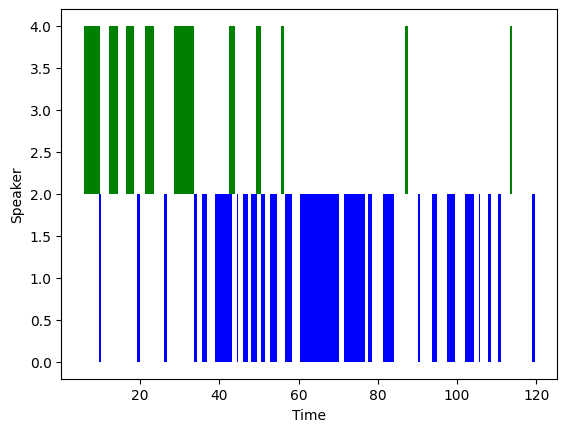

In [204]:
# Create an empty figure
fig = plt.figure()

# Loop through the list of tuples
colors = ["blue", "green"]
for k in range(0, 2):
    for speech in speech_turns[k]:
        start_time = speech[0]
        end_time = speech[1]
        # Plot a horizontal bar for each tuple
        plt.broken_barh([(start_time, end_time - start_time)], (2*k, 2), facecolors=colors[k])
# Add x and y-axis labels
plt.xlabel('Time')
plt.ylabel('Speaker')
# Display the plot
plt.show()

In [207]:
t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
for i in range(0, len(voice_activity)):
    print(voice_activity[i])
    

{'start': '00:00:00.000000', 'end': '00:00:05.880937', 'duration': 5.880937, 'label': 'silence', 'asr': ''}
{'start': '00:00:05.880937', 'end': '00:00:07.045312', 'duration': 1.164374, 'label': 'sound', 'asr': 'ai'}
{'start': '00:00:07.045312', 'end': '00:00:10.082812', 'duration': 3.0375, 'label': 'sound', 'asr': 'thanks for meeting me awsafraid you would'}
{'start': '00:00:10.082812', 'end': '00:00:12.242812', 'duration': 2.16, 'label': 'silence', 'asr': ''}
{'start': '00:00:12.242812', 'end': '00:00:12.614063', 'duration': 0.37125, 'label': 'sound', 'asr': 'wow'}
{'start': '00:00:12.614063', 'end': '00:00:13.997813', 'duration': 1.38375, 'label': 'silence', 'asr': ''}
{'start': '00:00:13.997813', 'end': '00:00:19.887187', 'duration': 5.8893759999999995, 'label': 'sound', 'asr': "oki guss i want to say i'm sorry for what happened you guess"}
{'start': '00:00:19.887187', 'end': '00:00:21.321563', 'duration': 1.434376, 'label': 'silence', 'asr': ''}
{'start': '00:00:21.321563', 'end': 